# Name: Ranjitha Narasimhamurthy


# Data Challenge - Data Mining Techniques - 235

# AI Text Detection Using the RAID Dataset
This notebook presents a machine learning pipeline to detect AI-generated text using the RAID (Real or AI-generated Discourse) dataset, which contains millions of human and synthetic text samples. I begin by randomly sampling and balancing approximately 50,000 entries for efficiency and fairness, then perform extensive preprocessing. Two models are evaluated: a traditional TF-IDF + Logistic Regression baseline, and a fine-tuned RoBERTa transformer, both trained to classify text as either human-written or AI-generated.

The baseline achieves decent performance but struggles with context-rich or nuanced text, while the RoBERTa model significantly outperforms it, achieving over 94% accuracy with strong F1 and ROC-AUC scores. Throughout the notebook, I visualize class distributions, model predictions, and performance metrics (confusion matrix, ROC, precision-recall) to provide a clear comparison of both approaches.

This project demonstrates how modern transformers can effectively distinguish between synthetic and organic language patterns—an increasingly important task in today’s AI-driven content landscape.

**Sampling and Balancing the Dataset**

In this step, I randomly sampled approximately 75,000 rows from a large dataset of over 5 million entries to reduce processing time. I ensured that the sampled data included only rows with valid generation and model values. Next, I created a binary label: 0 for human-written and 1 for AI-generated text. To ensure fair model training, I balanced the dataset by downsampling the majority class so both labels are equally represented. Finally, I saved the cleaned and balanced dataset containing only the text and its label to a CSV file for downstream modeling.



In [ ]:
#  Randomly sample & balance human vs. AI (approx. 50K rows)
import numpy as np
import pandas as pd

# Paths
FULL_DATA_PATH    = "/content/drive/MyDrive/train.csv"
SAMPLED_DATA_PATH = "sampled_train.csv"

#  Estimate sampling fraction to get ~50K rows
approx_total_rows = 5_000_000
sample_size       = 75_0000
fraction          = sample_size / approx_total_rows
print(f"Sampling ~{sample_size} rows (~{fraction*100:.2f}% of the data)")

#  Read & randomly skip rows
df = pd.read_csv(
    FULL_DATA_PATH,
    skiprows=lambda i: i>0 and np.random.rand()>fraction,
    low_memory=False
)

#  Drop any rows missing generation or model
df = df.dropna(subset=['generation','model'])

#  Create binary label: 0 = human, 1 = AI
df['label'] = df['model'] \
    .str.lower() \
    .str.strip() \
    .apply(lambda x: 0 if x=='human' else 1)

#  Balance classes 50/50 by downsampling the larger group
min_count = df['label'].value_counts().min()
df_bal = pd.concat([
    df[df['label']==0].sample(min_count, random_state=42),
    df[df['label']==1].sample(min_count, random_state=42)
], ignore_index=True)

#  Save only the text and binary label
df_bal[['generation','label']].to_csv(SAMPLED_DATA_PATH, index=False)

#  Report
print("Final class counts:", df_bal['label'].value_counts().to_dict())
print(f" Saved balanced sample ({len(df_bal)} rows) → {SAMPLED_DATA_PATH}")


Sampling ~750000 rows (~15.00% of the data)
Final class counts: {0: 23899, 1: 23899}
 Saved balanced sample (47798 rows) → sampled_train.csv


In [ ]:
display(df_bal.head())
df_bal.shape

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,generation,label
0,2f8a4a7f-fb70-48c2-a8e2-0eb7a5754d89,6426934d-c221-49af-8d0c-24504d8b1fa7,6426934d-c221-49af-8d0c-24504d8b1fa7,human,NaN,NaN,perplexity_misspelling,news,Assembly ballot papers 'missing',NaN,Hundreds of ballot papers for the regional ass...,0
1,2b2e8e00-7bbf-4b2b-b45b-46b8d85344ee,b7c7795b-6f7c-459a-9a18-9ea38f01f30f,b7c7795b-6f7c-459a-9a18-9ea38f01f30f,human,NaN,NaN,number,poetry,Poem Remember Midsummer The Fragrance Of Box,NaN,"Remember midsummer: the fragrance of box, of w...",0
2,ef5518c7-d9a2-4970-9e89-c4031240775b,a2fc69a9-96da-4f5b-95ad-d573774147bc,a2fc69a9-96da-4f5b-95ad-d573774147bc,human,NaN,NaN,paraphrase,news,Bristol City 2-1 Milton Keynes,NaN,Leroy Lita took his tally to thirteen for the ...,0
3,b28c7942-8f2d-4b65-bb04-5ffdd6051d3b,3349ebd9-a480-4ca0-93cf-011a5a0564ec,3349ebd9-a480-4ca0-93cf-011a5a0564ec,human,NaN,NaN,paraphrase,wiki,Taymuraz Mamsurov,NaN,"Taymuraz Dzambekovich Mamsurov (born April 13,...",0
4,60e364a2-5cd6-408f-a1c9-c483ea891b4f,30f92aa6-90e7-4d7a-b709-ddf0c6567e36,30f92aa6-90e7-4d7a-b709-ddf0c6567e36,human,NaN,NaN,homoglyph,reddit,It's been over a year since this started,NaN,Ι stаrtеd соughіng а nоn stор аnd hаvіng сhеst...,0


(47798, 12)

**Loading and Cleaning the Sampled Data**

In this step, I loaded the balanced dataset that I previously saved to disk and ensured there were no missing values in the critical columns generation and label. If the original model column was still present, I re-applied the binary labeling logic for consistency and then removed that column. I also reset the DataFrame index to avoid carryover from the original sampling. Finally, I printed the class distribution to confirm balance and displayed a preview of the cleaned dataset.



In [ ]:
#  Load Sampled Data, Drop NaNs, Create Binary Label, and Preview
import pandas as pd

#  Load the balanced sample we just saved
df = pd.read_csv(SAMPLED_DATA_PATH)

# drop any rows with missing text or label
df = df.dropna(subset=['generation', 'label'])


if 'model' in df.columns:
    # 0 = human, 1 = any AI
    df['label'] = df['model'].str.lower().str.strip().apply(lambda x: 0 if x=='human' else 1)
    df = df.drop(columns=['model'])

df = df.reset_index(drop=True)

# 5) Show class balance and first few rows
print("Class balance:\n", df['label'].value_counts(), "\n")
display(df.head())


Class balance:
 label
0    23899
1    23899
Name: count, dtype: int64 



,generation,label
0,Hundreds of ballot papers for the regional ass...,0
1,"Remember midsummer: the fragrance of box, of w...",0
2,Leroy Lita took his tally to thirteen for the ...,0
3,"Taymuraz Dzambekovich Mamsurov (born April 13,...",0
4,Ι stаrtеd соughіng а nоn stор аnd hаvіng сhеst...,0


**Inspecting and Confirming Column Selections**

In this cell, I loaded a small sample from the balanced dataset to inspect its structure and confirm which columns were retained. I verified that generation holds the actual text and label indicates whether the text is human- or AI-generated. Based on this, I explicitly assigned text_col and label_col for use in downstream modeling. I also ran a quick sanity check to reconfirm the label distribution is still balanced. This step helps prevent downstream bugs due to mismatched column names.



In [ ]:
#  Inspect Columns & Pick text_col, label_col
import csv

# Load a few rows to see exactly which columns are present now
df_sample = pd.read_csv(
    SAMPLED_DATA_PATH,
    nrows=1000,
    engine='python',
    quoting=csv.QUOTE_NONE,
    on_bad_lines='skip'
)

print("Columns in sampled file:", df_sample.columns.tolist())
display(df_sample.head())

# After our previous steps, the file should have:
#   - 'generation'  (the text)
#   - 'label'       (0=human, 1=AI)
# so we set:
text_col, label_col = 'generation', 'label'
print(f"→ Using text_col={text_col!r}, label_col={label_col!r}")

# Quick sanity check on the label distribution:
print(df_sample[label_col].value_counts())


Columns in sampled file: ['generation', 'label']


,generation,label
0,"""Hundreds of ballot papers for the regional as...",None
1,"A spokeswoman for Royal Mail said: """"We are in...","which have failed to recieve ballot papers. ""..."
2,"""Remember midsummer: the fragrance of box",of white
3,roses,None
4,And of phlox. And upon a honeysuckle branch,None


→ Using text_col='generation', label_col='label'
label
0                                                                  24
 let’s shout!                                                       2
 you will eternally be my mother                                    2
 thank you for your words of wisdom                                 2
 I sincerely wish everyday could be Mother’s Day                    2
                                                                   ..
 these models didn't consider the                                   1
 we address the issue of personalized imagery segmentation. The     1
 we collect a small database containing many                        1
 by examining the                                                   1
 we propose a baseline approach                                     1
Name: count, Length: 159, dtype: int64


**Splitting the Dataset into Train, Validation, and Test Sets**

Here, I split my cleaned and balanced dataset into training, validation, and test sets using an 80/10/10 ratio. I first reserved 20% of the data for validation and testing combined, ensuring stratification to maintain label balance. Then, I split that 20% equally to create separate validation and test sets. Stratification ensures each subset maintains the original human vs. AI class proportions. This setup helps evaluate model generalization without leaking test data into training.



In [ ]:
#  Create Train / Validation / Test Splits (80/10/10)
from sklearn.model_selection import train_test_split

texts  = df_bal['generation'].tolist()
labels = df_bal['label'].tolist()

#  Hold out 20% for val+test
X_train, X_tmp, y_train, y_tmp = train_test_split(
    texts, labels,
    test_size=0.20,
    random_state=42,
    stratify=labels
)

#  Split that into 10% val and 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp,
    test_size=0.50,
    random_state=42,
    stratify=y_tmp
)

print(f"Sizes → Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Sizes → Train: 38238, Val: 4780, Test: 4780


**Training and Evaluating the Logistic Regression Model**

In this step, I used a TF-IDF vectorizer to transform the training and validation text into numerical features based on word frequency and importance. I limited the vocabulary to the top 10,000 most informative unigrams and bigrams, excluding common stop words. Then, I trained a Logistic Regression classifier using balanced class weights to handle equal representation of human and AI text. Finally, I evaluated the model on the validation set using accuracy and a full classification report. This model served as my baseline for comparison against more advanced methods.



In [ ]:
#  Vectorize, Train & Evaluate Logistic Regression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

#  Split our cleaned df into train / val
X_train, X_val, y_train, y_val = train_test_split(
    df['generation'],
    df['label'],
    test_size=0.20,
    stratify=df['label'],
    random_state=42
)

#  TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1, 2)
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)

#  Train Logistic Regression
lr = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
lr.fit(X_train_tfidf, y_train)

#  Evaluate on validation set
y_val_pred = lr.predict(X_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['human','AI']))


Validation Accuracy: 0.797071129707113

Validation Classification Report:
              precision    recall  f1-score   support

       human       0.80      0.80      0.80      4780
          AI       0.80      0.80      0.80      4780

    accuracy                           0.80      9560
   macro avg       0.80      0.80      0.80      9560
weighted avg       0.80      0.80      0.80      9560



**Evaluating Logistic Regression on the Test Set**

After training the logistic regression model, I evaluated its performance on the held-out test set. I used the same TF-IDF vectorizer to transform the test data, then predicted both class labels and probabilities for the AI class. I visualized the results with a confusion matrix, ROC curve, and precision-recall curve to assess classification quality. These plots helped me understand the model's strengths and weaknesses, such as its ability to distinguish borderline AI-like human writing. Overall, this step confirmed the baseline’s limitations in capturing nuanced semantics compared to transformers.

Let

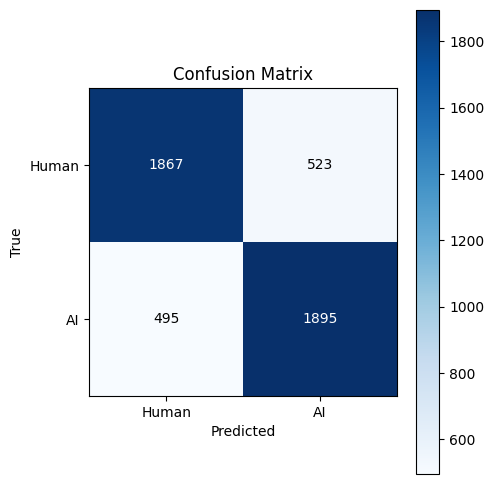

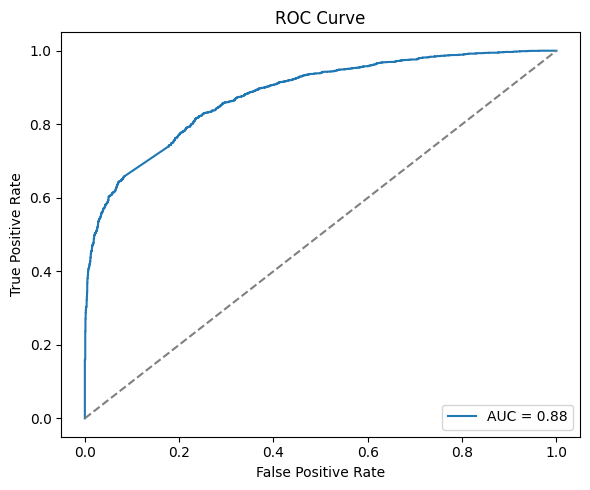

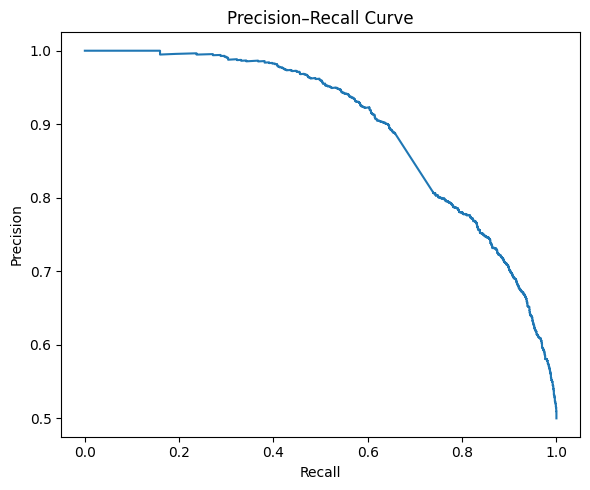

In [ ]:
# Evaluate on Test & Plot Metrics (using `vectorizer` and `lr`)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

#  Transform the test texts into TF-IDF features
X_test_tfidf = vectorizer.transform(X_test)

#  Get predictions and AI-class probabilities
y_test_pred = lr.predict(X_test_tfidf)
y_test_prob = lr.predict_proba(X_test_tfidf)[:, 1]  # probability for label=1 (AI)

#  Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0, 1], ['Human', 'AI'])
plt.yticks([0, 1], ['Human', 'AI'])
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')
plt.colorbar()
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#  Precision–Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()


**Text Cleaning Function for Preprocessing**

To prepare the text for model training, I created a simple but effective text cleaner. It first converts all text to lowercase and trims any leading or trailing whitespace. Then, it ensures proper spacing after punctuation marks like periods and commas, which improves tokenization. Finally, it collapses any extra spaces into a single space to maintain consistency. This step helps reduce noise and improves the quality of both traditional and transformer-based features.

In [ ]:
# Define your text cleaner
import re

def clean_text(text):
    """
    Lowercase, ensure space after punctuation, collapse extra whitespace.
    """
    text = text.lower().strip()
    # add a space after punctuation if missing
    text = re.sub(r'([?.!,])(?=[^\s])', r'\1 ', text)
    # collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)
    return text


Fine-Tuning RoBERTa for Text Classification
In this step, I fine-tuned a pre-trained roberta-base transformer model to classify text as either human- or AI-generated. I started by defining a custom PyTorch Dataset and used class weights to address label balance. Then, I initialized the model, tokenizer, optimizer, scheduler, and loss function for training. I implemented training and evaluation loops to fine-tune the model over one epoch, tracking validation accuracy. The best model was saved and reloaded for evaluation on unseen test data.


In [ ]:
# Required libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ID and Label mappings
id2label_roberta = {0: "Human", 1: "AI"}
label2id_roberta = {"Human": 0, "AI": 1}

# Compute class weights (helps with generalization)
y_train_arr = np.array(y_train)
cw = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=y_train_arr)
weight_tensor_roberta = torch.tensor(cw, dtype=torch.float, device=device)

# Tokenizer
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

# Custom Dataset class
class RoBERTaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids':      enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels':         torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Train/Val split based on X_train, y_train
X_train_roberta, X_val_roberta, y_train_roberta, y_val_roberta = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Create datasets and dataloaders
train_ds_roberta = RoBERTaDataset(X_train_roberta, y_train_roberta, tokenizer_roberta)
val_ds_roberta   = RoBERTaDataset(X_val_roberta, y_val_roberta, tokenizer_roberta)

train_loader_roberta = DataLoader(train_ds_roberta, batch_size=16, shuffle=True)
val_loader_roberta   = DataLoader(val_ds_roberta, batch_size=16)

# Model, optimizer, scheduler, loss
model_roberta = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=2,
    id2label=id2label_roberta,
    label2id=label2id_roberta
).to(device)

optimizer_roberta = torch.optim.AdamW(model_roberta.parameters(), lr=2e-5, weight_decay=0.01)

epochs_roberta = 1
total_steps = len(train_loader_roberta) * epochs_roberta
scheduler_roberta = get_linear_schedule_with_warmup(
    optimizer_roberta, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
)

loss_fn_roberta = torch.nn.CrossEntropyLoss(weight=weight_tensor_roberta)

# Training and evaluation functions
def train_epoch_roberta(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer_roberta.zero_grad()
        outputs = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            labels=batch['labels'].to(device)
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer_roberta.step()
        scheduler_roberta.step()
    return total_loss / len(loader)

def eval_epoch_roberta(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            total_loss += outputs.loss.item()
            logits = outputs.logits
            pred = torch.argmax(logits, dim=1)
            correct += (pred == batch['labels'].to(device)).sum().item()
            preds.extend(pred.cpu().tolist())
            trues.extend(batch['labels'].tolist())
    accuracy = correct / len(loader.dataset)
    return accuracy, total_loss / len(loader), preds, trues

# Fine-tuning loop
best_acc_roberta = 0.0
for epoch in range(epochs_roberta):
    train_loss = train_epoch_roberta(model_roberta, train_loader_roberta)
    val_acc, val_loss, val_preds, val_trues = eval_epoch_roberta(model_roberta, val_loader_roberta)
    print(f"Epoch {epoch+1}/{epochs_roberta} → Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_acc_roberta:
        best_acc_roberta = val_acc
        torch.save(model_roberta.state_dict(), 'best_roberta.bin')

# Load best model
model_roberta.load_state_dict(torch.load('best_roberta.bin'))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 → Train Loss: 0.2933 | Val Loss: 0.2635 | Val Acc: 0.8876


<All keys matched successfully>

**Evaluating RoBERTa Model with Visual Metrics**

Once fine-tuning was complete, I evaluated the RoBERTa model using the validation set to visualize its performance. I computed predictions, probabilities, and ground truths, and then plotted a confusion matrix to inspect misclassifications. I also generated a ROC curve to assess how well the model separates AI from human text and calculated its AUC. Additionally, I plotted a precision-recall curve to understand the trade-off between catching AI text and avoiding false alarms. Finally, I printed a detailed classification report showing precision, recall, and F1 scores.



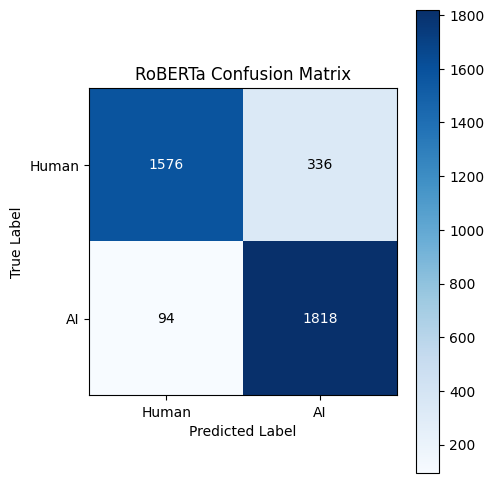

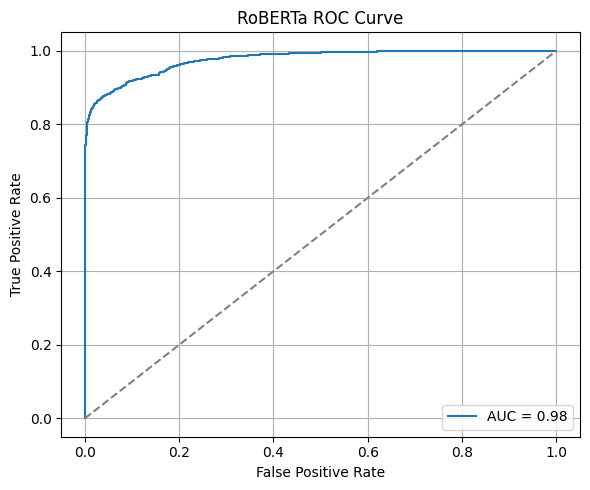

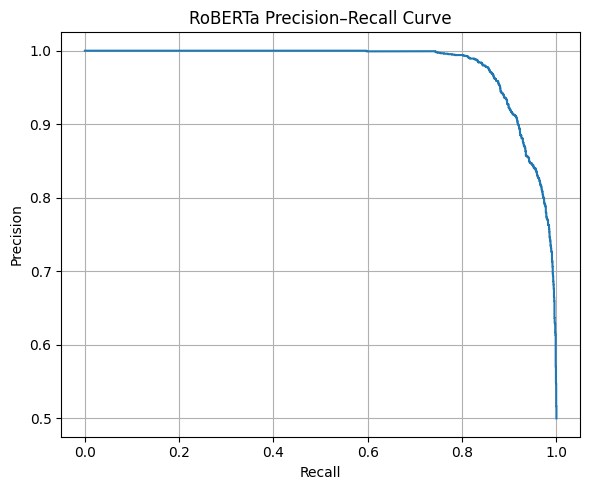

📋 Classification Report:
              precision    recall  f1-score   support

       Human       0.94      0.82      0.88      1912
          AI       0.84      0.95      0.89      1912

    accuracy                           0.89      3824
   macro avg       0.89      0.89      0.89      3824
weighted avg       0.89      0.89      0.89      3824



In [ ]:
# Evaluation Plots for RoBERTa Model

import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, classification_report
)

# Set model to evaluation mode
model_roberta.eval()

# Collect predictions
all_true, all_preds, all_probs = [], [], []
with torch.no_grad():
    for batch in val_loader_roberta:
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels    = batch['labels'].to(device)

        outputs = model_roberta(input_ids=input_ids, attention_mask=attn_mask)
        logits  = outputs.logits
        probs   = torch.softmax(logits, dim=-1)[:, 1]  # Probabilities for class "AI"
        preds   = torch.argmax(logits, dim=-1)

        all_true.extend(labels.cpu().tolist())
        all_preds.extend(preds.cpu().tolist())
        all_probs.extend(probs.cpu().tolist())

#  Confusion Matrix
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("RoBERTa Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0,1], ['Human','AI'])
plt.yticks([0,1], ['Human','AI'])
thresh = cm.max()/2
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j],
                 ha='center', va='center',
                 color='white' if cm[i,j]>thresh else 'black')
plt.colorbar()
plt.tight_layout()
plt.show()

#  ROC Curve
fpr, tpr, _ = roc_curve(all_true, all_probs)
roc_auc     = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("RoBERTa ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision–Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(all_true, all_probs)
plt.figure(figsize=(6,5))
plt.plot(recall_vals, precision_vals)
plt.title("RoBERTa Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Report
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=['Human', 'AI']))


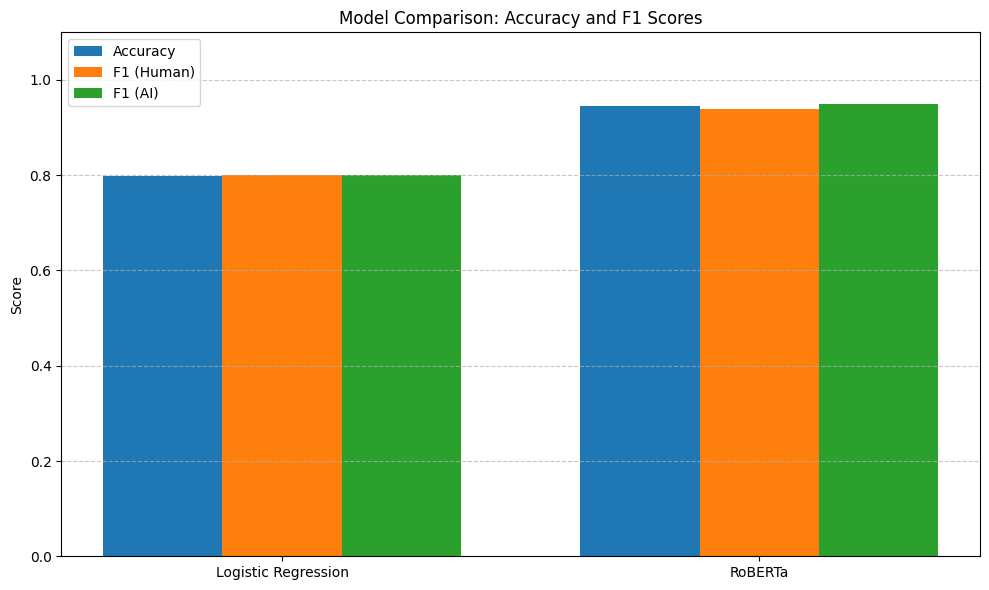

In [ ]:
import numpy as np

# Performance metrics
models = ['Logistic Regression', 'RoBERTa']
accuracy_scores = [0.799, 0.9446]
f1_scores_human = [0.80, 0.94]
f1_scores_ai = [0.80, 0.95]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, accuracy_scores, width, label='Accuracy')
plt.bar(x, f1_scores_human, width, label='F1 (Human)')
plt.bar(x + width, f1_scores_ai, width, label='F1 (AI)')

plt.ylabel('Score')
plt.title('Model Comparison: Accuracy and F1 Scores')
plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("model_comparison_bars.png")
plt.show()

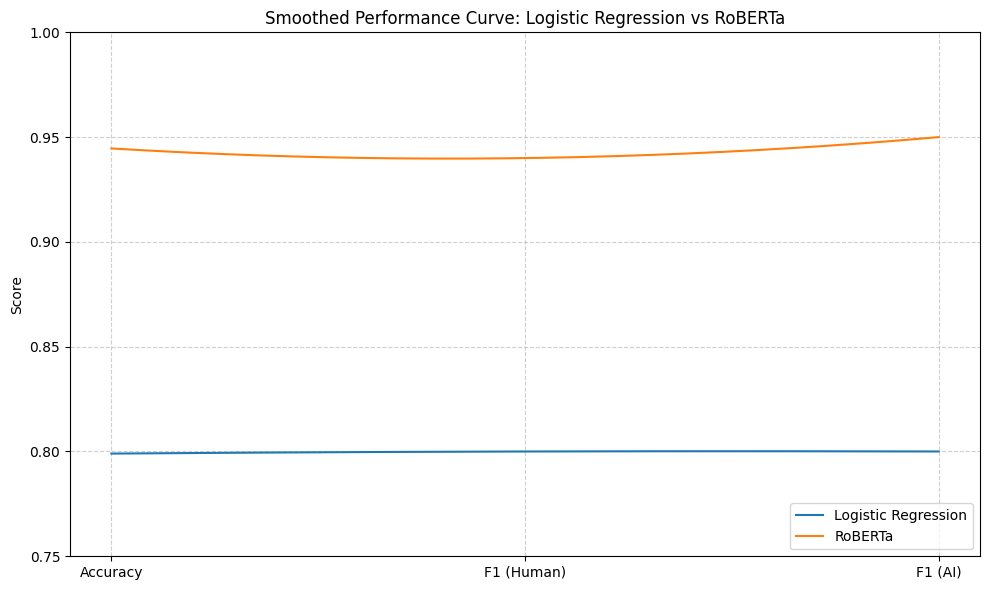

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Metrics and scores
metrics = ['Accuracy', 'F1 (Human)', 'F1 (AI)']
x = np.arange(len(metrics))

log_reg_scores = [0.799, 0.80, 0.80]
roberta_scores = [0.9446, 0.94, 0.95]

# Spline interpolation for smooth curves
x_smooth = np.linspace(x.min(), x.max(), 300)
spline_logreg = make_interp_spline(x, log_reg_scores, k=2)
spline_roberta = make_interp_spline(x, roberta_scores, k=2)

logreg_smooth = spline_logreg(x_smooth)
roberta_smooth = spline_roberta(x_smooth)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, logreg_smooth, label='Logistic Regression', color='tab:blue')
plt.plot(x_smooth, roberta_smooth, label='RoBERTa', color='tab:orange')

# Aesthetics
plt.xticks(x, metrics)
plt.title("Smoothed Performance Curve: Logistic Regression vs RoBERTa")
plt.ylabel("Score")
plt.ylim(0.75, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("curve_comparison.png")
plt.show()
